In [1]:
import numpy as np
from matplotlib import pyplot as plt
import sys
sys.path.append("../../Functions")
from GS_waves import select_freq_range, propagation_ew
from abtem.waves import PlaneWave
from Column_matching import Bessel_transform
from Defocus_circle import generate_continious_phase
import Generate_structure
from ase.visualize.plot import plot_atoms
from ase.io import read, write
from Complex_Gaussian import(
    Gaussian_function,
    Gaussian_in_focus,
    Gaussian_fitting,
    Modified_Gaussian_fitting,
    Gaussian_function_partition
)
from lmfit import Model
from scipy.optimize import minimize

In [13]:
#Parameters to set
gmin = 0; gmax = 2; sampling = 0.0656015; energy = 300e3
a = 4.05; length = 50; cut_factor = 0.01
krange = np.linspace(gmin+cut_factor, gmax, length)
#Results from isolated column
n_repeat = 4
thickness = 20
structure = Generate_structure.generate_periodic_fcc("Al", a, n_repeat, n_repeat, thickness)
exitwave = select_freq_range(np.array(PlaneWave(sampling=sampling, energy=energy).multislice(structure).array),
                            gmin, gmax, sampling)
m, n = exitwave.shape
exitwave = exitwave[(n_repeat*2-1)*m//(n_repeat*4):(n_repeat*2+1)*m//(n_repeat*4),
                        (n_repeat*2-1)*n//(n_repeat*4):(n_repeat*2+1)*n//(n_repeat*4)]
m, n = exitwave.shape
exitwave = exitwave - 1
exitwave = propagation_ew(exitwave, 10, sampling, energy)
x0, y0 = np.unravel_index(np.argmax(np.abs(exitwave)), exitwave.shape)
results, components = Bessel_transform(exitwave, sampling, gmin+cut_factor, gmax, length, 
                                       x0=(x0-(m-1)/2)*sampling, y0=(y0-(n-1)/2)*sampling)

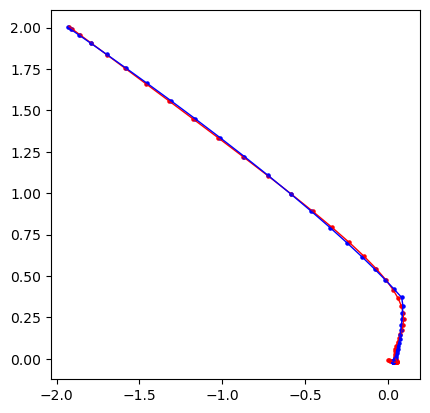

In [14]:
coeff = Modified_Gaussian_fitting(results, krange)
recover = Gaussian_function_partition(coeff, krange)
plt.plot(np.real(results), np.imag(results) ,color='r', linewidth=1)
plt.scatter(np.real(results), np.imag(results) ,color='r', s=5)
plt.plot(np.real(recover), np.imag(recover) ,color='b', linewidth=1)
plt.scatter(np.real(recover), np.imag(recover) ,color='b', s=5)
plt.axis("square")
plt.show()

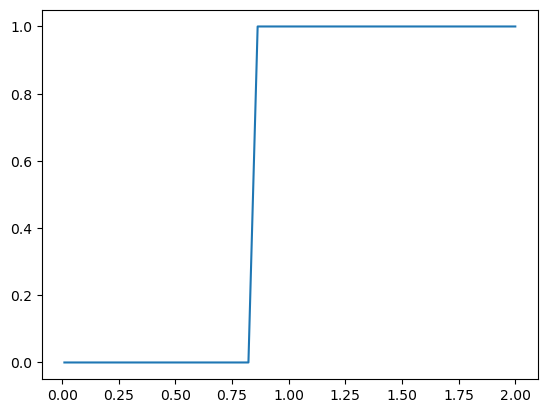

In [15]:
k_thres = coeff[0]; factor = coeff[1]
weight = 0.5 * (1 + np.tanh(-factor *(k_thres**2-krange**2)))
plt.plot(krange, weight)
plt.show()

Step 1: initial Gaussian fitting

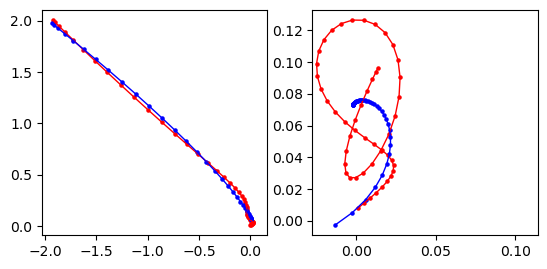

In [101]:
krange = np.linspace(gmin+0.01, gmax, length)
fitted = Gaussian_fitting(results, krange, [gmin+0.01, gmax], defocus=True)
coeff = np.array(list(fitted.best_values.values()))
bg = coeff[-2] + 1j*coeff[-1]
recover = Gaussian_function(krange, *coeff)
residue = results - recover + bg
fit_res = Gaussian_fitting(residue, krange, [gmin+0.01, gmax], defocus=True)
coeff_res = np.array(list(fit_res.best_values.values()))
bg_res = coeff_res[-2] + 1j*coeff_res[-1]
recover_res = Gaussian_function(krange, *coeff_res)
plt.subplot(1, 2, 1)
plt.plot(np.real(results), np.imag(results) ,color='r', linewidth=1)
plt.scatter(np.real(results), np.imag(results) ,color='r', s=5)
plt.plot(np.real(recover), np.imag(recover) ,color='b', linewidth=1)
plt.scatter(np.real(recover), np.imag(recover) ,color='b', s=5)
plt.axis("square")
plt.subplot(1, 2, 2)
plt.plot(np.real(residue), np.imag(residue), color='r', linewidth=1)
plt.scatter(np.real(residue), np.imag(residue) , color='r', s=5)
plt.plot(np.real(recover_res), np.imag(recover_res), color='b', linewidth=1)
plt.scatter(np.real(recover_res), np.imag(recover_res) , color='b', s=5)
plt.axis("square")
plt.show()

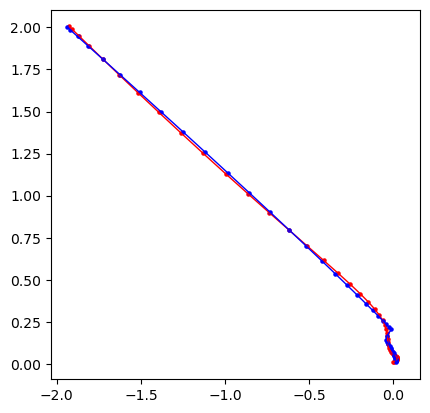

In [102]:
def partitioned_Gaussian_fit(coeffs):
    k_thres = coeffs[0]
    factor = coeffs[1]
    coeffs = coeffs[2:].reshape(2, -1)
    a_re, a_im, b_re, b_im, c_re, c_im = coeffs[0,:]
    theta = -b_im * krange**2
    y1_re = c_re + np.exp(-b_re * krange**2) * (a_re*np.cos(theta) - a_im*np.sin(theta))
    y1_im = c_im + np.exp(-b_re * krange**2) * (a_re*np.sin(theta) + a_im*np.cos(theta))
    a_re, a_im, b_re, b_im, c_re, c_im = coeffs[1,:]
    y1 = y1_re + 1j*y1_im
    theta = -b_im * krange**2
    y2_re = c_re + np.exp(-b_re * krange**2) * (a_re*np.cos(theta) - a_im*np.sin(theta))
    y2_im = c_im + np.exp(-b_re * krange**2) * (a_re*np.sin(theta) + a_im*np.cos(theta))
    y2 = y2_re + 1j*y2_im
    #weight = 1/(1+np.exp(-factor*(k_thres**2-krange**2)))
    weight = 0.5 * (1 + np.tanh(-factor*(k_thres**2-krange**2)))
    recover = y2*weight + y1*(1-weight)
    return np.linalg.norm(np.abs(recover-results))
def Gaussian_funtion_partition(coeffs):
    k_thres = coeffs[0]
    factor = coeffs[1]
    coeffs = coeffs[2:].reshape(2, -1)
    a_re, a_im, b_re, b_im, c_re, c_im = coeffs[0,:]
    theta = -b_im * krange**2
    y1_re = c_re + np.exp(-b_re * krange**2) * (a_re*np.cos(theta) - a_im*np.sin(theta))
    y1_im = c_im + np.exp(-b_re * krange**2) * (a_re*np.sin(theta) + a_im*np.cos(theta))
    a_re, a_im, b_re, b_im, c_re, c_im = coeffs[1,:]
    y1 = y1_re + 1j*y1_im
    theta = -b_im * krange**2
    y2_re = c_re + np.exp(-b_re * krange**2) * (a_re*np.cos(theta) - a_im*np.sin(theta))
    y2_im = c_im + np.exp(-b_re * krange**2) * (a_re*np.sin(theta) + a_im*np.cos(theta))
    y2 = y2_re + 1j*y2_im
    #weight = 1/(1+np.exp(-factor*(k_thres**2-krange**2)))
    weight = 0.5 * (1 + np.tanh(-factor*(k_thres**2-krange**2)))
    return y2*weight + y1*(1-weight)
coeffs=np.hstack((1, 50, coeff, coeff_res)).ravel()
res = minimize(partitioned_Gaussian_fit, coeffs, method="BFGS")
coeffs_fit = res.x
recover = Gaussian_funtion_partition(coeffs_fit)
plt.plot(np.real(results), np.imag(results) ,color='r', linewidth=1)
plt.scatter(np.real(results), np.imag(results) ,color='r', s=5)
plt.plot(np.real(recover), np.imag(recover) ,color='b', linewidth=1)
plt.scatter(np.real(recover), np.imag(recover) ,color='b', s=5)
plt.axis("square")
plt.show()

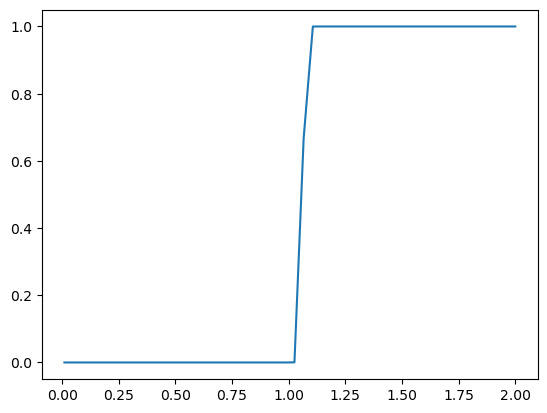

In [103]:
k_thres = coeffs_fit[0]; factor = coeffs_fit[1]
weight = 0.5 * (1 + np.tanh(-factor *(k_thres**2-krange**2)))
plt.plot(krange, weight)
plt.show()

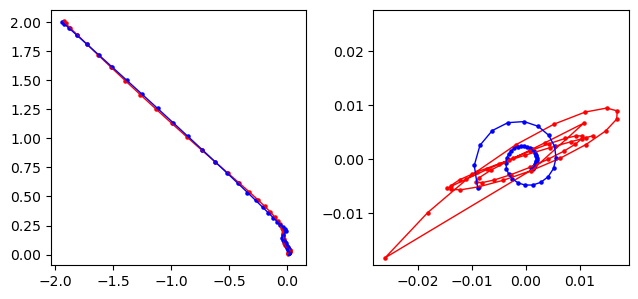

In [104]:
residue = results - recover
fit_res = Gaussian_fitting(residue, krange, [gmin+0.01, gmax], defocus=True)
coeff_res = np.array(list(fit_res.best_values.values()))
bg_res = coeff_res[-2] + 1j*coeff_res[-1]
recover_res = Gaussian_function(krange, *coeff_res)
plt.subplot(1, 2, 1)
plt.plot(np.real(results), np.imag(results) ,color='r', linewidth=1)
plt.scatter(np.real(results), np.imag(results) ,color='r', s=5)
plt.plot(np.real(recover), np.imag(recover) ,color='b', linewidth=1)
plt.scatter(np.real(recover), np.imag(recover) ,color='b', s=5)
plt.axis("square")
plt.subplot(1, 2, 2)
plt.plot(np.real(residue), np.imag(residue), color='r', linewidth=1)
plt.scatter(np.real(residue), np.imag(residue) , color='r', s=5)
plt.plot(np.real(recover_res), np.imag(recover_res), color='b', linewidth=1)
plt.scatter(np.real(recover_res), np.imag(recover_res) , color='b', s=5)
plt.axis("square")
plt.tight_layout()
plt.show()